In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from operator import itemgetter
from millet import SupervTransformer, UnsupervTransformer, BaseDataLoader, MultiPipeline

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [3]:
X_train, y_train = newsgroups_train.data, newsgroups_train.target

X_fit, X_val, y_fit, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [4]:
fit_data = {'X': X_train, 'y': y_train}
ens_data = {'X': X_val, 'y': y_val}
test_data = {'X': newsgroups_test.data, 'y': newsgroups_test.target}

In [5]:
class SimpleDataLoader(BaseDataLoader):
    def load_data(self, input_info):
        out_dict = {'X': input_info['X'],
                    'y': input_info['y']}
        return out_dict

In [6]:
class FeatConcatTransformer(UnsupervTransformer):
    def fit(self, input_dict):
        pass
    
    def transform(self, input_dict):
        X_stacked = np.hstack([v for k, v in sorted(input_dict.items(), key=itemgetter(0))])
        out_dict = {'X': X_stacked}
        return out_dict

In [7]:
class CountVecTransformer(UnsupervTransformer):
    def __init__(self):
        self.cvec = CountVectorizer()
        
    def fit(self, input_dict):
        self.cvec.fit(input_dict['X'])
    
    def transform(self, input_dict):
        return {'X': self.cvec.transform(input_dict['X'])}

In [8]:
class MyTfidfTransformer(UnsupervTransformer):
    def __init__(self):
        self.tfidf = TfidfTransformer()
        
    def fit(self, input_dict):
        self.tfidf.fit(input_dict['X'])
        
    def transform(self, input_dict):
        return {'X': self.tfidf.transform(input_dict['X'])}

In [9]:
class SvdTransformer(UnsupervTransformer):
    def __init__(self):
        self.tfm = TruncatedSVD(n_components=200)
        
    def fit(self, input_dict):
        self.tfm.fit(input_dict['X'])
        
    def transform(self, input_dict):
        return {'X': self.tfm.transform(input_dict['X'])}

In [10]:
class XgbTransformer(SupervTransformer):
    def __init__(self):
        self.clf = XGBClassifier(n_jobs=4)
        
    def fit(self, input_dict, superv_dict):
        self.clf.fit(input_dict['X'], superv_dict['y'])
        
    def transform(self, input_dict):
        return {'y': self.clf.predict_proba(input_dict['X'])}

In [11]:
class LogRegTransformer(SupervTransformer):
    def __init__(self):
        self.clf = LogisticRegression()
        
    def fit(self, input_dict, superv_dict):
        self.clf.fit(input_dict['X'], superv_dict['y'])
        
    def transform(self, input_dict):
        return {'y': self.clf.predict_proba(input_dict['X'])}

In [12]:
mpp = MultiPipeline()

mpp.add_dataloader(SimpleDataLoader(),
                   node_name='LOAD')

mpp.add_unsuperv(CountVecTransformer(),
                 node_name='CountVec',
                 input_mapping={'X': ('LOAD', 'X')})  

mpp.add_unsuperv(MyTfidfTransformer(),
                 node_name='TFIDF',
                 input_mapping={'X': ('CountVec', 'X')})

mpp.add_unsuperv(SvdTransformer(),
                 node_name='SVD',
                 input_mapping={'X': ('TFIDF', 'X')})

mpp.add_superv(XgbTransformer(),
               node_name='XGB',
               input_mapping={'X': ('SVD', 'X')},
               superv_mapping={'y': ('LOAD', 'y')})

mpp.add_superv(LogRegTransformer(),
               node_name='LogReg',
               input_mapping={'X': ('TFIDF', 'X')},
               superv_mapping={'y': ('LOAD', 'y')})

mpp.add_unsuperv(FeatConcatTransformer(),
                 node_name='FeatConcat',
                 input_mapping={'X1': ('XGB', 'y'), 'X2': ('LogReg', 'y')})

mpp.add_superv(LogRegTransformer(),
               node_name='EnsLogReg',
               input_mapping={'X': ('FeatConcat', 'X')},
               superv_mapping={'y': ('LOAD', 'y')})

In [13]:
mpp.print()

LOAD 4
CountVec {'source_data_keys': {'X': 'X'}}
XGB {'source_superv_keys': {'y': 'y'}}
LogReg {'source_superv_keys': {'y': 'y'}}
EnsLogReg {'source_superv_keys': {'y': 'y'}}
CountVec 1
TFIDF {'source_data_keys': {'X': 'X'}}
TFIDF 2
SVD {'source_data_keys': {'X': 'X'}}
LogReg {'source_data_keys': {'X': 'X'}}
SVD 1
XGB {'source_data_keys': {'X': 'X'}}
XGB 1
FeatConcat {'source_data_keys': {'X1': 'y'}}
LogReg 1
FeatConcat {'source_data_keys': {'X2': 'y'}}
FeatConcat 1
EnsLogReg {'source_data_keys': {'X': 'X'}}
EnsLogReg 0


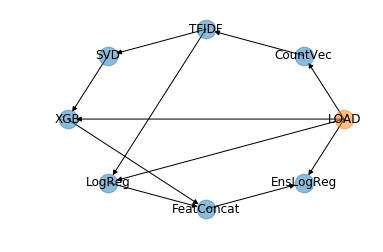

In [14]:
mpp.draw()
plt.axis('off');

In [15]:
submodel_fit_out = mpp.run(fit_data, 
                           fit_node_names=['CountVec', 'TFIDF', 'SVD', 'XGB', 'LogReg'], 
                           output_node_names=['XGB', 'LogReg'])

[MultiPipeline] Clearing output of node_name: LOAD
[MultiPipeline] Clearing output of node_name: CountVec
[MultiPipeline] Clearing output of node_name: TFIDF
[MultiPipeline] Clearing output of node_name: SVD
[MultiPipeline] Clearing output of node_name: XGB
[MultiPipeline] Clearing output of node_name: LogReg
[MultiPipeline] Clearing output of node_name: FeatConcat
[MultiPipeline] Clearing output of node_name: EnsLogReg
[MultiPipeline] Running node LOAD
[MultiPipeline]   Calling load_data
[MultiPipeline] Running node CountVec
[MultiPipeline]   Translating inputs
[MultiPipeline]     Forwarding data LOAD:X to data CountVec:X
[MultiPipeline]   Calling fit_transform with input_dict dict_keys(['X'])
[MultiPipeline] Running node TFIDF
[MultiPipeline]   Translating inputs
[MultiPipeline]     Forwarding data CountVec:X to data TFIDF:X
[MultiPipeline]   Calling fit_transform with input_dict dict_keys(['X'])
[MultiPipeline] Running node LogReg
[MultiPipeline]   Translating inputs
[MultiPipeline]

In [16]:
ens_fit_out = mpp.run(ens_data, fit_node_names=['EnsLogReg'] , output_node_names=['EnsLogReg'])

[MultiPipeline] Clearing output of node_name: LOAD
[MultiPipeline] Clearing output of node_name: CountVec
[MultiPipeline] Clearing output of node_name: TFIDF
[MultiPipeline] Clearing output of node_name: SVD
[MultiPipeline] Clearing output of node_name: XGB
[MultiPipeline] Clearing output of node_name: LogReg
[MultiPipeline] Clearing output of node_name: FeatConcat
[MultiPipeline] Clearing output of node_name: EnsLogReg
[MultiPipeline] Running node LOAD
[MultiPipeline]   Calling load_data
[MultiPipeline] Running node CountVec
[MultiPipeline]   Translating inputs
[MultiPipeline]     Forwarding data LOAD:X to data CountVec:X
[MultiPipeline]   Calling transform with input_dict dict_keys(['X'])
[MultiPipeline] Running node TFIDF
[MultiPipeline]   Translating inputs
[MultiPipeline]     Forwarding data CountVec:X to data TFIDF:X
[MultiPipeline]   Calling transform with input_dict dict_keys(['X'])
[MultiPipeline] Running node LogReg
[MultiPipeline]   Translating inputs
[MultiPipeline]     For

In [17]:
test_out = mpp.run(test_data, fit_node_names=[], output_node_names=['XGB', 'LogReg', 'EnsLogReg'])

[MultiPipeline] Clearing output of node_name: LOAD
[MultiPipeline] Clearing output of node_name: CountVec
[MultiPipeline] Clearing output of node_name: TFIDF
[MultiPipeline] Clearing output of node_name: SVD
[MultiPipeline] Clearing output of node_name: XGB
[MultiPipeline] Clearing output of node_name: LogReg
[MultiPipeline] Clearing output of node_name: FeatConcat
[MultiPipeline] Clearing output of node_name: EnsLogReg
[MultiPipeline] Running node LOAD
[MultiPipeline]   Calling load_data
[MultiPipeline] Running node CountVec
[MultiPipeline]   Translating inputs
[MultiPipeline]     Forwarding data LOAD:X to data CountVec:X
[MultiPipeline]   Calling transform with input_dict dict_keys(['X'])
[MultiPipeline] Running node TFIDF
[MultiPipeline]   Translating inputs
[MultiPipeline]     Forwarding data CountVec:X to data TFIDF:X
[MultiPipeline]   Calling transform with input_dict dict_keys(['X'])
[MultiPipeline] Running node LogReg
[MultiPipeline]   Translating inputs
[MultiPipeline]     For

In [18]:
print('XGB test log-loss: {:.4f}'.format(log_loss(y_true=test_data['y'], y_pred=test_out['XGB']['y'])))
print('LogReg test log-loss: {:.4f}'.format(log_loss(y_true=test_data['y'], y_pred=test_out['LogReg']['y'])))
print('Ensemble test log-loss: {:.4f}'.format(log_loss(y_true=test_data['y'], y_pred=test_out['EnsLogReg']['y'])))

XGB test log-loss: 1.7335
LogReg test log-loss: 1.6760
Ensemble test log-loss: 1.6848
